<a href="https://colab.research.google.com/github/yyduyuxuan/Machine-Learning-for-Data-Driven-Inventory-Replenishment-Evidence-from-the-M5-Retail-Dataset/blob/main/TRAIN_Fine_Tuning_3y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

try:
    model = LGBMRegressor(device='gpu', n_estimators=10)
    print("✅ GPU setting accepted.")
except:
    print("❌ GPU setting not supported by current LightGBM.")


✅ GPU setting accepted.


In [ ]:
# Install the GPU version of LightGBM
!apt-get install -y -qq libboost-all-dev
!pip uninstall -y lightgbm -q
!git clone --recursive https://github.com/microsoft/LightGBM
%cd LightGBM
!mkdir build
%cd build
!cmake -DUSE_GPU=1 ..
!make -j4
%cd ../python-package
!python setup.py install


Cloning into 'LightGBM'...
remote: Enumerating objects: 35473, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 35473 (delta 169), reused 87 (delta 87), pack-reused 35219 (from 2)
Receiving objects: 100% (35473/35473), 24.03 MiB | 32.12 MiB/s, done.
Resolving deltas: 100% (26370/26370), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21818, done.        
remote: Counting objects: 100% (40/40), done.        
r

In [ ]:
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

from math import ceil

from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

In [ ]:
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2)

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [ ]:
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

file_path = '/content/drive/MyDrive/Colab Notebooks/Supervised Project/sales_long_val_5y.pkl'
sales_long_val = pd.read_pickle(file_path)

print(sales_long_val.shape)
sales_long_val.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(45974682, 119)


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,enc_mean_store_id_cat_id,enc_std_store_id_cat_id,enc_mean_store_id_dept_id,enc_std_store_id_dept_id,enc_mean_item_id,enc_std_item_id,enc_mean_item_id_state_id,enc_std_item_id_state_id,enc_mean_item_id_store_id,enc_std_item_id_store_id
0,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1,3,2011-01-29,11101,...,2.75,6.753906,1.662109,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375
1,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2,0,2011-01-30,11101,...,2.75,6.753906,1.662109,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375
2,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,0,2011-01-31,11101,...,2.75,6.753906,1.662109,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375
3,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,4,1,2011-02-01,11101,...,2.75,6.753906,1.662109,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375
4,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,5,4,2011-02-02,11101,...,2.75,6.753906,1.662109,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375


In [ ]:
# Group
group_key = ['store_id', 'dept_id']

group_names = sales_long_val[group_key].drop_duplicates().values.tolist()
print(f"Total groups: {len(group_names)}")

Total groups: 70


In [ ]:
sales_long_val['d'].min(), sales_long_val['d'].max()

(np.int16(1), np.int16(1913))

# Data grouping

In [ ]:
# Remove features not used in training (usually unique identifiers, raw fields)
remove_feature = [
    'id',
    #'state_id',
    'store_id',
    #'cat_id',
    #'item_id',
    'dept_id',
    'date',
    'd',
    'wm_yr_wk',
    'sales'
]

# Build a set of categorical variables (including original + new)
cat_var = [
    'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id',
    'event_name_1', 'event_name_2', 'event_type_1', 'event_type_2',
    'snap_CA', 'snap_TX', 'snap_WI',
    'is_weekend',
    'price_change_flag',
    'is_discontinued'
]

# Remove those features we marked as "remove_feature"
cat_var = list(set(cat_var) - set(remove_feature))

# Finally, cat_var is the list of category variables
print("Final categorical variables used for training:")
print(cat_var)

Final categorical variables used for training:
['price_change_flag', 'store_id', 'is_weekend', 'snap_CA', 'event_name_1', 'is_discontinued', 'event_type_2', 'snap_WI', 'event_type_1', 'event_name_2', 'item_id', 'cat_id', 'snap_TX']


In [ ]:
id_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'date', 'wm_yr_wk']
lag_features = [
    'lag_1', 'lag_7', 'lag_14', 'lag_28',
    'lag_29', 'lag_30', 'lag_31', 'lag_32', 'lag_33', 'lag_34',
    'lag_35', 'lag_36', 'lag_37', 'lag_38', 'lag_39', 'lag_40',
    'lag_41', 'lag_42'
]
lag_diff_features = ['lag_1_minus_7', 'lag_7_minus_14', 'lag_14_minus_28']

rolling_features = [
    'rolling_mean_7', 'rolling_std_7',
    'rolling_mean_14', 'rolling_std_14',
    'rolling_mean_30', 'rolling_std_30',
    'rolling_mean_60', 'rolling_std_60',
    'rolling_mean_180', 'rolling_std_180'
]

rolling_tmp_features = [
    'rolling_mean_tmp_1_7', 'rolling_mean_tmp_1_14', 'rolling_mean_tmp_1_30', 'rolling_mean_tmp_1_60',
    'rolling_mean_tmp_7_7', 'rolling_mean_tmp_7_14', 'rolling_mean_tmp_7_30', 'rolling_mean_tmp_7_60',
    'rolling_mean_tmp_14_7', 'rolling_mean_tmp_14_14', 'rolling_mean_tmp_14_30', 'rolling_mean_tmp_14_60'
]

intermittency_features = ['ADI_30', 'CV2_30', 'ADI_60', 'CV2_60', 'ADI_90', 'CV2_90']

time_features = ['weekday', 'wday', 'month', 'year', 'day_of_year', 'sin_doy', 'cos_doy',
                 'tm_w', 'tm_m', 'tm_y', 'tm_wm', 'tm_dw', 'tm_w_end', 'is_weekend']

event_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
                  'snap_CA', 'snap_TX', 'snap_WI']

price_features = [
    'sell_price', 'price_lag_7', 'price_change_flag', 'price_max', 'price_min',
    'price_mean', 'price_std', 'price_norm', 'price_nunique', 'item_nunique',
    'price_momentum', 'price_momentum_m', 'price_momentum_y'
]

lifecycle_features = ['release', 'is_discontinued']


mean_encoding_features = [
    'enc_mean_state_id', 'enc_std_state_id',
    'enc_mean_store_id', 'enc_std_store_id',
    'enc_mean_cat_id', 'enc_std_cat_id',
    'enc_mean_dept_id', 'enc_std_dept_id',
    'enc_mean_state_id_cat_id', 'enc_std_state_id_cat_id',
    'enc_mean_state_id_dept_id', 'enc_std_state_id_dept_id',
    'enc_mean_store_id_cat_id', 'enc_std_store_id_cat_id',
    'enc_mean_store_id_dept_id', 'enc_std_store_id_dept_id',
    'enc_mean_item_id', 'enc_std_item_id',
    'enc_mean_item_id_state_id', 'enc_std_item_id_state_id',
    'enc_mean_item_id_store_id', 'enc_std_item_id_store_id'
]

In [ ]:
feature_cols = (
    lag_features + lag_diff_features + rolling_features + rolling_tmp_features +
    intermittency_features + time_features + event_features + price_features +
    lifecycle_features + mean_encoding_features
)

# ML Forecasting

In [ ]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from tqdm import tqdm

# LightGBM Parameter settings
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'tweedie',
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'tweedie_variance_power': 1.1,
    'metric': 'rmse',
    'subsample': 0.7,
    'subsample_freq': 1,
    'learning_rate': 0.02,
    'num_leaves': 2**7 - 1,
    'min_data_in_leaf': 2**6 - 1,
    'feature_fraction': 0.7,
    'max_bin': 100,
    'n_estimators': 2500,
    'boost_from_average': False,
    'verbose': -1,
    'seed': 1995
}


In [ ]:
import time
import numpy as np
import pandas as pd
import lightgbm as lgb
from tqdm import tqdm

def holdout_predict_only(
    data: pd.DataFrame,
    group_key: list,
    remove_feature: list,
    target_col: str = 'ROP_L3',
    train_range: tuple = (None, None),  # (train_start_d, train_end_d)
    val_range: tuple = (None, None),    # (val_start_d, val_end_d)
    lgb_params: dict | None = None,
    return_models: bool = False
):

    tr_start, tr_end = train_range
    vl_start, vl_end = val_range
    assert None not in train_range + val_range, "Train and validation ranges cannot be None."

    pred_rows, models = [], {}

    for grp_vals, gdf in tqdm(
        data.groupby(group_key, sort=False), desc="Hold-out training → validation predict"
    ):
        # train/val split
        tr_mask = (gdf['d'] >= tr_start) & (gdf['d'] <= tr_end)
        vl_mask = (gdf['d'] >= vl_start) & (gdf['d'] <= vl_end)

        X_tr = gdf.loc[tr_mask].drop(columns=remove_feature + [target_col], errors='ignore')
        y_tr = gdf.loc[tr_mask, target_col]
        X_vl = gdf.loc[vl_mask].drop(columns=remove_feature + [target_col], errors='ignore')
        y_vl = gdf.loc[vl_mask, target_col]

        if X_tr.empty or X_vl.empty:
            continue


        t0 = time.time()
        model = lgb.LGBMRegressor(**(lgb_params or {}))
        model.fit(X_tr, y_tr)
        train_secs = time.time() - t0


        y_hat = model.predict(X_vl)
        out = gdf.loc[vl_mask, ['d'] + group_key].copy()
        out['true'] = y_vl.values
        out['pred'] = y_hat
        out['train_secs'] = train_secs
        pred_rows.append(out)

        if return_models:
            gid = "_".join(map(str, grp_vals))
            models[gid] = model

    preds_df = pd.concat(pred_rows, axis=0).reset_index(drop=True) if pred_rows else pd.DataFrame()
    return (preds_df, models) if return_models else preds_df

In [ ]:
print("Memory after base data merge:", get_memory_usage(), "GB")
sales_long_val = reduce_mem_usage(sales_long_val)

Memory after base data merge: 11.72 GB
Mem. usage decreased to 11750.43 Mb (0.0% reduction)


In [ ]:
from sklearn.preprocessing import LabelEncoder

for col in ['weekday']:
    if sales_long_val[col].dtype == 'object':
        le = LabelEncoder()
        sales_long_val[col] = le.fit_transform(sales_long_val[col])


In [ ]:
!pip install tqdm

# Result & Model Save

In [ ]:
label_col = 'ROP_L3'
group_key = ['store_id', 'dept_id']
remove_feature=[
        # ID
        'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
        'd', 'date', 'wm_yr_wk','sales',

        # ROP label
        'ROP_L3', 'ROP_L7', 'ROP_L14',

        # mean encoding, avoid target leakage
        'enc_mean_store_id', 'enc_std_store_id',
        'enc_mean_dept_id', 'enc_std_dept_id',
        'enc_mean_store_id_cat_id', 'enc_std_store_id_cat_id',
        'enc_mean_state_id_dept_id', 'enc_std_state_id_dept_id',
        'enc_mean_store_id_dept_id', 'enc_std_store_id_dept_id',
        'enc_mean_item_id_store_id', 'enc_std_item_id_store_id']

In [ ]:
# Window Inspection
import pandas as pd
import numpy as np

def verify_ranges(df, date_col='date', d_col='d'):
    df = df.copy()
    if not np.issubdtype(df[date_col].dtype, np.datetime64):
        df[date_col] = pd.to_datetime(df[date_col])

    start_date = df[date_col].min().normalize()
    y3_end = start_date + pd.DateOffset(years=3) - pd.Timedelta(days=1)
    y4_end = start_date + pd.DateOffset(years=4) - pd.Timedelta(days=1)

    d_start = int(df.loc[df[date_col] == start_date, d_col].min())
    d_y3_end = int(df.loc[df[date_col] <= y3_end, d_col].max())
    d_y4_end = int(df.loc[df[date_col] <= y4_end, d_col].max())

    print(f"start_date={start_date.date()}  -> d_start={d_start}")
    print(f"Y3 end   ={y3_end.date()}      -> d_y3_end={d_y3_end}")
    print(f"Y4 end   ={y4_end.date()}      -> d_y4_end={d_y4_end}")
    print(f"Train d-range = [{d_start}, {d_y3_end}]")
    print(f"Val   d-range = [{d_y3_end+1}, {d_y4_end}]")

    assert d_start == 1, "The starting point is not 1."
    assert (d_y3_end - d_start + 1) == ((y3_end - start_date).days + 1), "The training window is not equal to 3 years."
    assert (d_y4_end - d_y3_end) == ((y4_end - y3_end).days), "The validation window is not equal to 1 year."

verify_ranges(sales_long_val, date_col='date', d_col='d')


start_date=2011-01-29  -> d_start=1
Y3 end   =2014-01-28      -> d_y3_end=1096
Y4 end   =2015-01-28      -> d_y4_end=1461
Train d-range = [1, 1096]
Val   d-range = [1097, 1461]


In [ ]:
import os, gc, pickle, time
import numpy as np
import pandas as pd
import lightgbm as lgb
from tqdm import tqdm

# Calculate the d interval for 3-year training + 1-year validation based on the data starting date
def make_ranges_by_df(df, years_train=3, date_col='date', d_col='d'):
    df = df.copy()
    if not np.issubdtype(df[date_col].dtype, np.datetime64):
        df[date_col] = pd.to_datetime(df[date_col])

    start_date = df[date_col].min().normalize()
    y3_end_date = start_date + pd.DateOffset(years=3) - pd.Timedelta(days=1)
    y4_end_date = start_date + pd.DateOffset(years=4) - pd.Timedelta(days=1)

    # Map date boundaries to d index (robust: take the largest d <= boundary date)
    d_y3_end = int(df.loc[df[date_col] <= y3_end_date, d_col].max())
    d_y4_end = int(df.loc[df[date_col] <= y4_end_date, d_col].max())

    # Starting from start_date
    train_start_date = y3_end_date - pd.DateOffset(years=years_train) + pd.Timedelta(days=1)
    d_train_start = int(df.loc[df[date_col] >= train_start_date, d_col].min())

    train_range = (d_train_start, d_y3_end)      # [1, 1096]
    val_range   = (d_y3_end + 1, d_y4_end)       # [1097, 1461]
    info = {
        "start_date": start_date.date(),
        "y3_end_date": y3_end_date.date(),
        "y4_end_date": y4_end_date.date(),
        "train_range_d": train_range,
        "val_range_d": val_range,
    }
    return train_range, val_range, info

# LightGBM
def _fit_lgb_safe(X_tr, y_tr, params):
    n = X_tr.shape[0]
    # Drop constant columns (including all NaNs/single values)
    const_cols = [c for c in X_tr.columns if X_tr[c].nunique(dropna=True) <= 1]
    if const_cols:
        X_tr = X_tr.drop(columns=const_cols)

    safe = dict(params or {})
    safe['min_data_in_leaf'] = max(5, min(safe.get('min_data_in_leaf', 20), max(2, n // 4)))
    safe['num_leaves']       = min(safe.get('num_leaves', 31), max(2, n - 1))
    safe['force_row_wise']   = True

    mdl = lgb.LGBMRegressor(**safe)
    mdl.fit(X_tr, y_tr)
    return mdl, const_cols

# Main function: group training
def run_train_val_3y1y(
    df, group_key, label_col, remove_feature, lgb_params,
    forecast_dir, model_dir,
    date_col='date', d_col='d'
):
    os.makedirs(forecast_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)

    train_range, val_range, info = make_ranges_by_df(df, years_train=3, date_col=date_col, d_col=d_col)
    print(f"[SPLIT] start={info['start_date']}, Y3_end={info['y3_end_date']}, "
          f"Y4_end={info['y4_end_date']}, train_d={info['train_range_d']}, val_d={info['val_range_d']}")

    for grp_vals, gdf in tqdm(df.groupby(group_key, sort=False), desc="Hold-out per group"):
        group_id = "_".join(map(str, grp_vals if isinstance(grp_vals, tuple) else (grp_vals,)))
        f_path = os.path.join(forecast_dir, f"forecast_{group_id}.pkl")
        m_path = os.path.join(model_dir,    f"model_{group_id}.bin")

        if os.path.exists(f_path) and os.path.exists(m_path):
            print(f"[Skip] {group_id} already processed.")
            continue

        # Split
        tr_mask = (gdf[d_col] >= train_range[0]) & (gdf[d_col] <= train_range[1])
        vl_mask = (gdf[d_col] >= val_range[0])   & (gdf[d_col] <= val_range[1])

        X_tr = gdf.loc[tr_mask].drop(columns=remove_feature + [label_col], errors='ignore')
        y_tr = gdf.loc[tr_mask, label_col]
        X_vl = gdf.loc[vl_mask].drop(columns=remove_feature + [label_col], errors='ignore')
        y_vl = gdf.loc[vl_mask, label_col]

        if X_tr.empty or X_vl.empty:
            print(f"[Warn] {group_id} no train/val rows. Skipped.")
            continue

        t0 = time.time()
        model, dropped_cols = _fit_lgb_safe(X_tr, y_tr, lgb_params)
        secs = time.time() - t0

        # Validation set predictions
        X_vl2 = X_vl.drop(columns=dropped_cols, errors='ignore')
        pred = model.predict(X_vl2)

        # Save results
        cols_keep = ['d', 'date']
        for c in ['item_id', 'store_id'] + (group_key if isinstance(group_key, list) else list(group_key)):
            if c in gdf.columns and c not in cols_keep:
                cols_keep.append(c)
        out = gdf.loc[vl_mask, cols_keep].copy()
        out['true'] = y_vl.values
        out['pred'] = pred
        out['train_secs'] = secs
        out.to_pickle(f_path)
        print(f"[Save] Forecast -> {f_path}")

        # Save models
        with open(m_path, 'wb') as f:
            pickle.dump(model, f)
        print(f"[Save] Model -> {m_path}")

        # Freeing memory
        del X_tr, y_tr, X_vl, y_vl, model, gdf, out
        gc.collect()

# Call
forecast_dir = "/content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/"
model_dir    = "/content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/"

run_train_val_3y1y(
    df=sales_long_val,
    group_key=group_key,
    label_col=label_col,
    remove_feature=remove_feature,
    lgb_params=lgb_params,
    forecast_dir=forecast_dir,
    model_dir=model_dir,
    date_col='date',
    d_col='d'
)


[SPLIT] start=2011-01-29, Y3_end=2014-01-28, Y4_end=2015-01-28, train_d=(1, 1096), val_d=(1097, 1461)


Hold-out per group:   0%|          | 0/70 [00:00<?, ?it/s]

[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_1_FOODS_1.pkl


Hold-out per group:   1%|▏         | 1/70 [01:30<1:44:31, 90.89s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_1_FOODS_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_2_FOODS_1.pkl


Hold-out per group:   3%|▎         | 2/70 [02:23<1:17:29, 68.38s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_2_FOODS_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_3_FOODS_1.pkl


Hold-out per group:   4%|▍         | 3/70 [03:15<1:08:09, 61.03s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_3_FOODS_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_4_FOODS_1.pkl


Hold-out per group:   6%|▌         | 4/70 [04:07<1:03:00, 57.27s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_4_FOODS_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_TX_1_FOODS_1.pkl


Hold-out per group:   7%|▋         | 5/70 [05:00<1:00:21, 55.71s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_TX_1_FOODS_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_TX_2_FOODS_1.pkl


Hold-out per group:   9%|▊         | 6/70 [05:53<58:25, 54.77s/it]  

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_TX_2_FOODS_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_TX_3_FOODS_1.pkl


Hold-out per group:  10%|█         | 7/70 [06:47<57:10, 54.46s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_TX_3_FOODS_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_WI_1_FOODS_1.pkl


Hold-out per group:  11%|█▏        | 8/70 [07:39<55:33, 53.76s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_WI_1_FOODS_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_WI_2_FOODS_1.pkl


Hold-out per group:  13%|█▎        | 9/70 [08:31<54:14, 53.35s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_WI_2_FOODS_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_WI_3_FOODS_1.pkl


Hold-out per group:  14%|█▍        | 10/70 [09:24<53:01, 53.02s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_WI_3_FOODS_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_1_FOODS_2.pkl


Hold-out per group:  16%|█▌        | 11/70 [10:28<55:33, 56.50s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_1_FOODS_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_2_FOODS_2.pkl


Hold-out per group:  17%|█▋        | 12/70 [11:11<50:41, 52.43s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_2_FOODS_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_3_FOODS_2.pkl


Hold-out per group:  19%|█▊        | 13/70 [12:16<53:23, 56.21s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_3_FOODS_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_4_FOODS_2.pkl


Hold-out per group:  20%|██        | 14/70 [13:19<54:19, 58.20s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_4_FOODS_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_TX_1_FOODS_2.pkl


Hold-out per group:  21%|██▏       | 15/70 [14:23<54:58, 59.98s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_TX_1_FOODS_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_TX_2_FOODS_2.pkl


Hold-out per group:  23%|██▎       | 16/70 [15:29<55:33, 61.73s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_TX_2_FOODS_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_TX_3_FOODS_2.pkl


Hold-out per group:  24%|██▍       | 17/70 [16:32<55:02, 62.32s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_TX_3_FOODS_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_WI_1_FOODS_2.pkl


Hold-out per group:  26%|██▌       | 18/70 [17:30<52:45, 60.88s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_WI_1_FOODS_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_WI_2_FOODS_2.pkl


Hold-out per group:  27%|██▋       | 19/70 [18:32<52:05, 61.28s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_WI_2_FOODS_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_WI_3_FOODS_2.pkl


Hold-out per group:  29%|██▊       | 20/70 [19:38<52:16, 62.74s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_WI_3_FOODS_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_1_FOODS_3.pkl


Hold-out per group:  30%|███       | 21/70 [21:13<59:05, 72.36s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_1_FOODS_3.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_2_FOODS_3.pkl


Hold-out per group:  31%|███▏      | 22/70 [22:44<1:02:17, 77.86s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_2_FOODS_3.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_3_FOODS_3.pkl


Hold-out per group:  33%|███▎      | 23/70 [24:17<1:04:41, 82.59s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_3_FOODS_3.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_4_FOODS_3.pkl


Hold-out per group:  34%|███▍      | 24/70 [25:49<1:05:29, 85.43s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_4_FOODS_3.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_TX_1_FOODS_3.pkl


Hold-out per group:  36%|███▌      | 25/70 [27:23<1:05:57, 87.95s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_TX_1_FOODS_3.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_TX_2_FOODS_3.pkl


Hold-out per group:  37%|███▋      | 26/70 [28:56<1:05:37, 89.48s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_TX_2_FOODS_3.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_TX_3_FOODS_3.pkl


Hold-out per group:  39%|███▊      | 27/70 [30:29<1:04:51, 90.50s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_TX_3_FOODS_3.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_WI_1_FOODS_3.pkl


Hold-out per group:  40%|████      | 28/70 [31:58<1:02:56, 89.92s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_WI_1_FOODS_3.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_WI_2_FOODS_3.pkl


Hold-out per group:  41%|████▏     | 29/70 [33:33<1:02:38, 91.67s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_WI_2_FOODS_3.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_WI_3_FOODS_3.pkl


Hold-out per group:  43%|████▎     | 30/70 [35:10<1:01:59, 92.99s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_WI_3_FOODS_3.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_1_HOBBIES_1.pkl


Hold-out per group:  44%|████▍     | 31/70 [36:16<55:19, 85.10s/it]  

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_1_HOBBIES_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_2_HOBBIES_1.pkl


Hold-out per group:  46%|████▌     | 32/70 [37:25<50:45, 80.15s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_2_HOBBIES_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_3_HOBBIES_1.pkl


Hold-out per group:  47%|████▋     | 33/70 [38:32<46:57, 76.16s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_3_HOBBIES_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_4_HOBBIES_1.pkl


Hold-out per group:  49%|████▊     | 34/70 [39:38<43:59, 73.32s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_4_HOBBIES_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_TX_1_HOBBIES_1.pkl


Hold-out per group:  50%|█████     | 35/70 [40:47<42:00, 72.02s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_TX_1_HOBBIES_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_TX_2_HOBBIES_1.pkl


Hold-out per group:  51%|█████▏    | 36/70 [41:54<39:54, 70.41s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_TX_2_HOBBIES_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_TX_3_HOBBIES_1.pkl


Hold-out per group:  53%|█████▎    | 37/70 [43:02<38:22, 69.79s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_TX_3_HOBBIES_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_WI_1_HOBBIES_1.pkl


Hold-out per group:  54%|█████▍    | 38/70 [44:11<37:06, 69.59s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_WI_1_HOBBIES_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_WI_2_HOBBIES_1.pkl


Hold-out per group:  56%|█████▌    | 39/70 [45:23<36:12, 70.09s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_WI_2_HOBBIES_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_WI_3_HOBBIES_1.pkl


Hold-out per group:  57%|█████▋    | 40/70 [46:33<35:02, 70.07s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_WI_3_HOBBIES_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_1_HOBBIES_2.pkl


Hold-out per group:  59%|█████▊    | 41/70 [47:18<30:12, 62.50s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_1_HOBBIES_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_2_HOBBIES_2.pkl


Hold-out per group:  60%|██████    | 42/70 [48:02<26:35, 56.97s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_2_HOBBIES_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_3_HOBBIES_2.pkl


Hold-out per group:  61%|██████▏   | 43/70 [48:47<24:00, 53.34s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_3_HOBBIES_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_4_HOBBIES_2.pkl


Hold-out per group:  63%|██████▎   | 44/70 [49:28<21:36, 49.87s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_4_HOBBIES_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_TX_1_HOBBIES_2.pkl


Hold-out per group:  64%|██████▍   | 45/70 [50:12<20:02, 48.08s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_TX_1_HOBBIES_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_TX_2_HOBBIES_2.pkl


Hold-out per group:  66%|██████▌   | 46/70 [50:58<18:55, 47.33s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_TX_2_HOBBIES_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_TX_3_HOBBIES_2.pkl


Hold-out per group:  67%|██████▋   | 47/70 [51:43<17:57, 46.84s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_TX_3_HOBBIES_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_WI_1_HOBBIES_2.pkl


Hold-out per group:  69%|██████▊   | 48/70 [52:27<16:51, 45.99s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_WI_1_HOBBIES_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_WI_2_HOBBIES_2.pkl


Hold-out per group:  70%|███████   | 49/70 [53:11<15:49, 45.20s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_WI_2_HOBBIES_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_WI_3_HOBBIES_2.pkl


Hold-out per group:  71%|███████▏  | 50/70 [53:55<15:00, 45.03s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_WI_3_HOBBIES_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_1_HOUSEHOLD_1.pkl


Hold-out per group:  73%|███████▎  | 51/70 [55:07<16:44, 52.87s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_1_HOUSEHOLD_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_2_HOUSEHOLD_1.pkl


Hold-out per group:  74%|███████▍  | 52/70 [56:19<17:35, 58.66s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_2_HOUSEHOLD_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_3_HOUSEHOLD_1.pkl


Hold-out per group:  76%|███████▌  | 53/70 [57:32<17:49, 62.90s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_3_HOUSEHOLD_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_4_HOUSEHOLD_1.pkl


Hold-out per group:  77%|███████▋  | 54/70 [58:42<17:23, 65.20s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_4_HOUSEHOLD_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_TX_1_HOUSEHOLD_1.pkl


Hold-out per group:  79%|███████▊  | 55/70 [59:54<16:46, 67.13s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_TX_1_HOUSEHOLD_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_TX_2_HOUSEHOLD_1.pkl


Hold-out per group:  80%|████████  | 56/70 [1:01:06<16:02, 68.78s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_TX_2_HOUSEHOLD_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_TX_3_HOUSEHOLD_1.pkl


Hold-out per group:  81%|████████▏ | 57/70 [1:02:19<15:09, 69.94s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_TX_3_HOUSEHOLD_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_WI_1_HOUSEHOLD_1.pkl


Hold-out per group:  83%|████████▎ | 58/70 [1:03:32<14:10, 70.84s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_WI_1_HOUSEHOLD_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_WI_2_HOUSEHOLD_1.pkl


Hold-out per group:  84%|████████▍ | 59/70 [1:04:45<13:04, 71.36s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_WI_2_HOUSEHOLD_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_WI_3_HOUSEHOLD_1.pkl


Hold-out per group:  86%|████████▌ | 60/70 [1:05:57<11:55, 71.55s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_WI_3_HOUSEHOLD_1.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_1_HOUSEHOLD_2.pkl


Hold-out per group:  87%|████████▋ | 61/70 [1:07:12<10:53, 72.60s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_1_HOUSEHOLD_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_2_HOUSEHOLD_2.pkl


Hold-out per group:  89%|████████▊ | 62/70 [1:08:27<09:48, 73.55s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_2_HOUSEHOLD_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_3_HOUSEHOLD_2.pkl


Hold-out per group:  90%|█████████ | 63/70 [1:09:44<08:41, 74.56s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_3_HOUSEHOLD_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_CA_4_HOUSEHOLD_2.pkl


Hold-out per group:  91%|█████████▏| 64/70 [1:10:58<07:26, 74.42s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_CA_4_HOUSEHOLD_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_TX_1_HOUSEHOLD_2.pkl


Hold-out per group:  93%|█████████▎| 65/70 [1:12:14<06:14, 74.85s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_TX_1_HOUSEHOLD_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_TX_2_HOUSEHOLD_2.pkl


Hold-out per group:  94%|█████████▍| 66/70 [1:13:31<05:02, 75.51s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_TX_2_HOUSEHOLD_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_TX_3_HOUSEHOLD_2.pkl


Hold-out per group:  96%|█████████▌| 67/70 [1:14:46<03:45, 75.15s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_TX_3_HOUSEHOLD_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_WI_1_HOUSEHOLD_2.pkl


Hold-out per group:  97%|█████████▋| 68/70 [1:16:00<02:29, 74.84s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_WI_1_HOUSEHOLD_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_WI_2_HOUSEHOLD_2.pkl


Hold-out per group:  99%|█████████▊| 69/70 [1:17:13<01:14, 74.50s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_WI_2_HOUSEHOLD_2.bin
[Save] Forecast -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/forecast_WI_3_HOUSEHOLD_2.pkl


Hold-out per group: 100%|██████████| 70/70 [1:18:28<00:00, 67.26s/it]

[Save] Model -> /content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/models_store_dept_3y1y/model_WI_3_HOUSEHOLD_2.bin


In [ ]:
import pandas as pd
import os
from glob import glob
from google.colab import drive
drive.mount('/content/drive')

new_results_dir = "/content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/train_store_dept_3y1y/"

file_list = glob(os.path.join(new_results_dir, "forecast_*.pkl"))

all_results = pd.concat([pd.read_pickle(f) for f in file_list], ignore_index=True)

all_results.head()


Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,d,date,item_id,store_id,dept_id,true,pred,train_secs
0,1097,2014-01-29,FOODS_1_001,CA_1,FOODS_1,0.0,0.015328,49.344443
1,1098,2014-01-30,FOODS_1_001,CA_1,FOODS_1,0.0,0.023159,49.344443
2,1099,2014-01-31,FOODS_1_001,CA_1,FOODS_1,0.0,0.031866,49.344443
3,1100,2014-02-01,FOODS_1_001,CA_1,FOODS_1,0.0,0.016470,49.344443
4,1101,2014-02-02,FOODS_1_001,CA_1,FOODS_1,0.0,0.007734,49.344443


In [ ]:
print(f"Total records: {all_results.shape[0]}")
print(f"Columns: {all_results.columns.tolist()}")

Total records: 10377296
Columns: ['d', 'date', 'item_id', 'store_id', 'dept_id', 'true', 'pred', 'train_secs']


# Evaluation with errors

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

def calculate_test_errors(test_series, forecast_series, train_series=None,
                          series_name='y', model_name='model', print_results=False):

    y_true = np.array(test_series)
    y_pred = np.array(forecast_series)

    # MAPE and sMAPE（escape 0）
    skip_mape = (y_true == 0).any()
    if not skip_mape:
        mape_val = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        smape_val = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

    # RMSE
    rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
    me_val = np.mean(y_pred - y_true)
    mean_test = np.mean(y_true)
    norm_rmse = rmse_val / mean_test
    norm_me = me_val / mean_test

    # RMSSE
    if train_series is not None:
        y_train = np.array(train_series)
        insample_naive = np.mean((y_train[1:] - y_train[:-1]) ** 2)
        rmsse_val = rmse_val / np.sqrt(insample_naive) if insample_naive > 0 else np.nan
    else:
        rmsse_val = np.nan

    if print_results:
        print(f"Model: {model_name} | Series: {series_name}")
        if not skip_mape:
            print(f"MAPE     : {mape_val:.2f}%")
            print(f"sMAPE    : {smape_val:.2f}%")
        print(f"RMSSE    : {rmsse_val:.3f}")
        print(f"RMSE     : {rmse_val:.3f}")
        print(f"Norm_RMSE: {norm_rmse:.3f}")
        print(f"ME       : {me_val:.3f}")
        print(f"Norm_ME  : {norm_me:.3f}")

    # DataFrame
    if not skip_mape:
        columns = ['SeriesName', 'Model', 'MAPE', 'sMAPE', 'RMSSE', 'RMSE', 'Norm_RMSE', 'ME', 'Norm_ME']
        values = [series_name, model_name, mape_val, smape_val, rmsse_val, rmse_val, norm_rmse, me_val, norm_me]
    else:
        columns = ['SeriesName', 'Model', 'RMSSE', 'RMSE', 'Norm_RMSE', 'ME', 'Norm_ME']
        values = [series_name, model_name, rmsse_val, rmse_val, norm_rmse, me_val, norm_me]

    return pd.DataFrame([values], columns=columns)


In [ ]:
import numpy as np
import pandas as pd

def evaluate_group_errors(
    result_df: pd.DataFrame,
    sales_long_val: pd.DataFrame,
    label_col: str,
    group_key: list,
    train_range: tuple = (1, 1096),   # validation window
    lead_time: int = 3,
    model_name: str = 'ML_Holdout'
):
    """
    result_df: Validation set details containing ['d', *group_key, 'true', 'pred']
    sales_long_val: Full history (at least ['d', 'sales', *group_key])
    label_col: Evaluation target ('ROP_L3')
    group_key: Grouping key (e.g., ['store_id', 'dept_id'])
    train_range: Constructs the RMSSE denominator using only the training window to prevent lookahead
    lead_time: L interval used for aggregation when label is ROP
    """

    error_summary = []
    tr_start, tr_end = train_range

    # groups
    for group_vals, gpred in result_df.groupby(group_key, sort=False):
        y_true = gpred['true'].to_numpy(dtype=float)
        y_pred = gpred['pred'].to_numpy(dtype=float)

        # Construct the history of this group + training window
        mask = np.ones(len(sales_long_val), dtype=bool)
        for k, v in zip(group_key, (group_vals if isinstance(group_vals, tuple) else (group_vals,))):
            mask &= (sales_long_val[k] == v)
        mask &= (sales_long_val['d'] >= tr_start) & (sales_long_val['d'] <= tr_end)

        g_hist = sales_long_val.loc[mask, ['d', 'sales']].sort_values('d')
        if g_hist.empty:
            train_series = None
        else:
            if 'ROP' in label_col.upper():
                # Construction within the training window ROP_train = rolling L day sum, forward L-1 anti-leakage
                rop_train = (
                    g_hist['sales']
                    .shift(-(lead_time - 1))
                    .rolling(lead_time)
                    .sum()
                )
                # Only ROPs that fall completely within the training window are retained (the last L-1 days without true values ​​are not counted)
                last_t = tr_end - (lead_time - 1)
                train_series = rop_train[g_hist['d'] <= last_t].dropna()
            else:
                # Daily sales
                train_series = g_hist['sales'].dropna()

            if train_series is not None and len(train_series) < 2:
                train_series = None

        # Error calculation
        res = calculate_test_errors(
            test_series=y_true,
            forecast_series=y_pred,
            train_series=train_series,
            series_name=str(group_vals),
            model_name=model_name,
            print_results=False
        )
        error_summary.append(res)

    return pd.concat(error_summary, ignore_index=True) if error_summary else pd.DataFrame()

In [ ]:
total_nan_rows = 0

for group_vals, group_df in all_results.groupby(group_key):
    nan_mask = group_df[['true', 'pred']].isna().any(axis=1)
    nan_count = nan_mask.sum()

    if nan_count > 0:
        print(f"Group {group_vals} has {nan_count} NaN rows.")
        total_nan_rows += nan_count

print(f" Total rows with NaN in 'true' or 'pred': {total_nan_rows}")


Group ('CA_1', 'FOODS_1') has 22 NaN rows.
Group ('CA_1', 'FOODS_2') has 130 NaN rows.
Group ('CA_1', 'FOODS_3') has 182 NaN rows.
Group ('CA_1', 'HOBBIES_1') has 66 NaN rows.
Group ('CA_1', 'HOBBIES_2') has 46 NaN rows.
Group ('CA_1', 'HOUSEHOLD_1') has 140 NaN rows.
Group ('CA_1', 'HOUSEHOLD_2') has 98 NaN rows.
Group ('CA_2', 'FOODS_1') has 22 NaN rows.
Group ('CA_2', 'FOODS_2') has 80 NaN rows.
Group ('CA_2', 'FOODS_3') has 226 NaN rows.
Group ('CA_2', 'HOBBIES_1') has 62 NaN rows.
Group ('CA_2', 'HOBBIES_2') has 42 NaN rows.
Group ('CA_2', 'HOUSEHOLD_1') has 156 NaN rows.
Group ('CA_2', 'HOUSEHOLD_2') has 110 NaN rows.
Group ('CA_3', 'FOODS_1') has 22 NaN rows.
Group ('CA_3', 'FOODS_2') has 124 NaN rows.
Group ('CA_3', 'FOODS_3') has 186 NaN rows.
Group ('CA_3', 'HOBBIES_1') has 64 NaN rows.
Group ('CA_3', 'HOBBIES_2') has 44 NaN rows.
Group ('CA_3', 'HOUSEHOLD_1') has 154 NaN rows.
Group ('CA_3', 'HOUSEHOLD_2') has 88 NaN rows.
Group ('CA_4', 'FOODS_1') has 26 NaN rows.
Group ('C

In [ ]:
nan_rows = all_results[['true', 'pred']].isna().any(axis=1).sum()

total_rows = len(all_results)

nan_ratio = nan_rows / total_rows

print(f"Number of rows containing NaNs: {nan_rows}")
print(f"Total number of rows: {total_rows}")
print(f"NaN percentage: {nan_ratio:.2%}")


Number of rows containing NaNs: 6974
Total number of rows: 10377296
NaN percentage: 0.07%


In [ ]:
all_results_clean = all_results.dropna(subset=['true', 'pred'])
error_df = evaluate_group_errors(result_df=all_results_clean,
                                 sales_long_val=sales_long_val,
                                 label_col=label_col,
                                 group_key=group_key)

In [ ]:
error_df.head(10)

,SeriesName,Model,RMSSE,RMSE,Norm_RMSE,ME,Norm_ME
0,"('CA_1', 'FOODS_1')",ML_Holdout,0.714531,3.375711,0.707822,-0.381018,-0.079892
1,"('CA_2', 'FOODS_1')",ML_Holdout,0.597432,3.542258,0.698133,-0.168272,-0.033164
2,"('CA_3', 'FOODS_1')",ML_Holdout,0.686002,4.058081,0.735551,-0.236788,-0.042919
3,"('CA_4', 'FOODS_1')",ML_Holdout,0.700626,2.233861,0.780213,-0.154787,-0.054062
4,"('TX_1', 'FOODS_1')",ML_Holdout,0.927050,3.047546,1.079793,-0.380435,-0.134794
5,"('TX_2', 'FOODS_1')",ML_Holdout,0.456646,2.822131,0.785422,-0.234683,-0.065314
6,"('TX_3', 'FOODS_1')",ML_Holdout,0.842993,3.172179,0.900793,-0.445858,-0.126609
7,"('WI_1', 'FOODS_1')",ML_Holdout,0.616250,2.587411,0.684662,-0.223458,-0.059130
8,"('WI_2', 'FOODS_1')",ML_Holdout,0.694685,3.792860,0.875028,-0.280073,-0.064614
9,"('WI_3', 'FOODS_1')",ML_Holdout,0.504957,2.232975,0.905671,-0.201762,-0.081832


In [ ]:
error_df.head(20)

,SeriesName,Model,RMSSE,RMSE,Norm_RMSE,ME,Norm_ME
0,"('CA_1', 'FOODS_1')",ML_Holdout,0.714531,3.375711,0.707822,-0.381018,-0.079892
1,"('CA_2', 'FOODS_1')",ML_Holdout,0.597432,3.542258,0.698133,-0.168272,-0.033164
2,"('CA_3', 'FOODS_1')",ML_Holdout,0.686002,4.058081,0.735551,-0.236788,-0.042919
3,"('CA_4', 'FOODS_1')",ML_Holdout,0.700626,2.233861,0.780213,-0.154787,-0.054062
4,"('TX_1', 'FOODS_1')",ML_Holdout,0.927050,3.047546,1.079793,-0.380435,-0.134794
5,"('TX_2', 'FOODS_1')",ML_Holdout,0.456646,2.822131,0.785422,-0.234683,-0.065314
6,"('TX_3', 'FOODS_1')",ML_Holdout,0.842993,3.172179,0.900793,-0.445858,-0.126609
7,"('WI_1', 'FOODS_1')",ML_Holdout,0.616250,2.587411,0.684662,-0.223458,-0.059130
8,"('WI_2', 'FOODS_1')",ML_Holdout,0.694685,3.792860,0.875028,-0.280073,-0.064614
9,"('WI_3', 'FOODS_1')",ML_Holdout,0.504957,2.232975,0.905671,-0.201762,-0.081832


In [ ]:
error_df.to_pickle("/content/drive/MyDrive/Colab Notebooks/Supervised Project/Fine Tuning/3y1y_error_df.pkl")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_true_vs_pred(df_forecast, true_col='true', pred_col='pred', n_points=140, title='Prediction vs True'):
    plt.figure(figsize=(18, 6))
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Value")


    y_true = df_forecast[true_col][-n_points:]
    y_pred = df_forecast[pred_col][-n_points:]

    sns.lineplot(x=y_true.index, y=y_true.values, label='True', color='black')
    sns.lineplot(x=y_pred.index, y=y_pred.values, label='Prediction', color='blue')

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
sample_group_df = all_results[
    (all_results['store_id'] == 'CA_1') &
    (all_results['dept_id'] == 'FOODS_1')
]


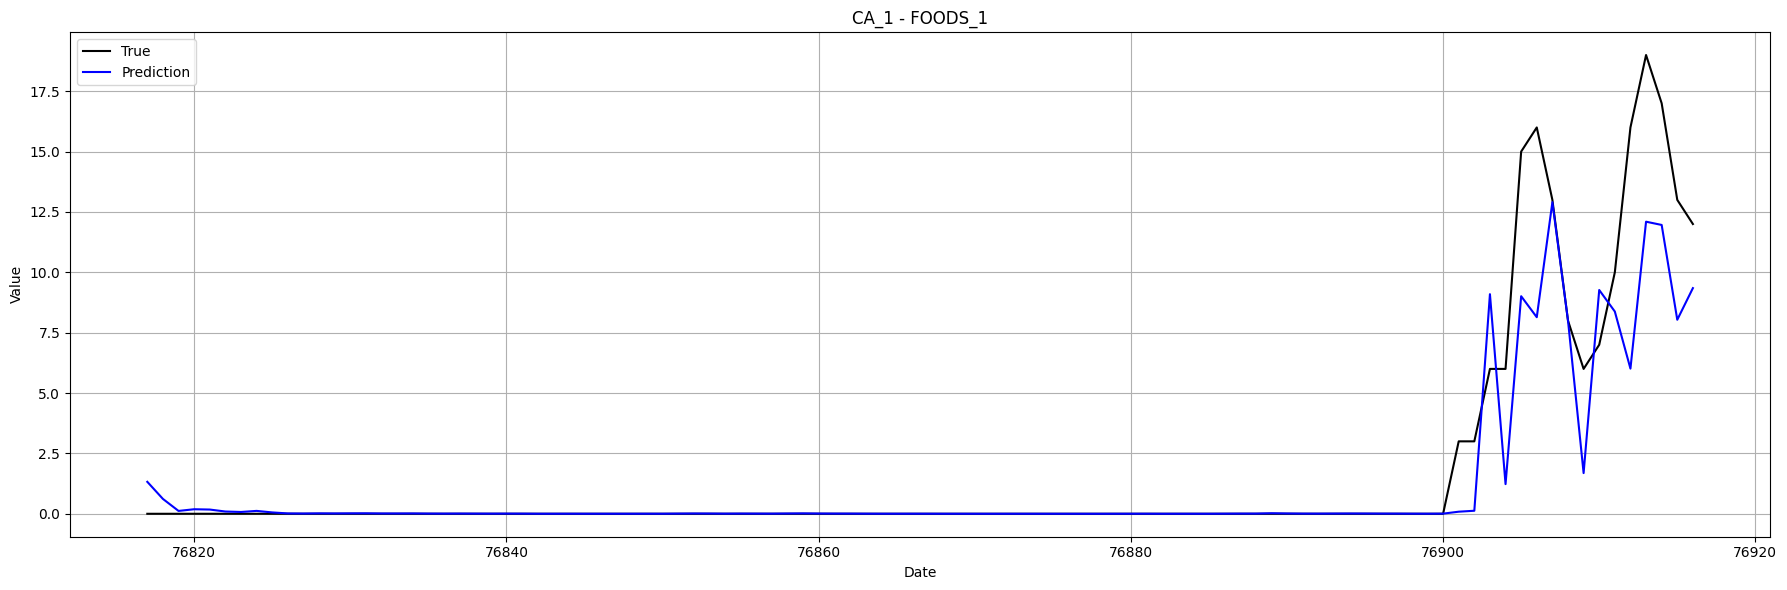

In [ ]:
plot_true_vs_pred(sample_group_df, true_col='true', pred_col='pred', n_points=100, title='CA_1 - FOODS_1')
